# 1. Twitch API data

The URL `https://wind-bow.glitch.me/twitch-api/channels/{CHANNEL_NAME}` is an API from twitch to get data from twitch channels.

Get the data from the following channels:

```
["ESL_SC2", "OgamingSC2", "cretetion", "freecodecamp", 
    "storbeck", "habathcx", "RobotCaleb", "noobs2ninjas",
    "ninja", "shroud", "Dakotaz", "esltv_cs", "pokimane", 
    "tsm_bjergsen", "boxbox", "wtcn", "a_seagull",
    "kinggothalion", "amazhs", "jahrein", "thenadeshot", 
    "sivhd", "kingrichard"]
```

To make into a dataframe that looks like this:

![](twitch.png)

In [1]:
import pandas as pd
import requests
import numpy as np
import json
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [121]:
twitch_channels = ["ESL_SC2", "OgamingSC2", "cretetion", "freecodecamp", 
    "storbeck", "habathcx", "RobotCaleb", "noobs2ninjas",
    "ninja", "shroud", "Dakotaz", "esltv_cs", "pokimane", 
    "tsm_bjergsen", "boxbox", "wtcn", "a_seagull",
    "kinggothalion", "amazhs", "jahrein", "thenadeshot", 
    "sivhd", "kingrichard"]

for t in twitch_channels:
    r = requests.get(f"https://wind-bow.glitch.me/twitch-api/channels/{t}")
    j = json.loads(r.content)
    #print(j['display_name'])

# Viewing which links actually give data
# Looks like only 8 channels are found to have data

#ESL_SC2
#OgamingSC2
#cretetion
#FreeCodeCamp
#storbeck
#Habathcx
#RobotCaleb
#noobs2ninjas

#So I'll work with these

In [130]:
twitch_c = ["ESL_SC2", "OgamingSC2", "cretetion", "freecodecamp", 
    "storbeck", "habathcx", "RobotCaleb", "noobs2ninjas"]

#Creating a list of dicts
channel_data = [] 

#Looping through to get all channel info and turn into dict
for t in twitch_c:
    response = requests.get(f"https://wind-bow.glitch.me/twitch-api/channels/{t}")
    jdict = json.loads(response.content)
    channel_data.append(jdict)

In [137]:
#Simply creating a dataframe and removing unwanted cols
df = pd.DataFrame(channel_data)
twitch_channel_info = df.drop(['mature', 'broadcaster_language','language','created_at','updated_at','delay','logo',
'banner','video_banner','background','profile_banner','profile_banner_background_color','partner','url','_links','name'], axis = 1) 


In [138]:
twitch_channel_info

,status,display_name,game,_id,views,followers
0,RERUN: StarCraft 2 - Terminator vs. Parting (P...,ESL_SC2,StarCraft II,30220059,60991791,135394
1,UnderDogs - Rediffusion - Qualifier.,OgamingSC2,StarCraft II,71852806,20694507,40895
2,It's a Divison kind of Day,cretetion,Tom Clancy's The Division,90401618,11631,908
3,Greg working on Electron-Vue boilerplate w/ Ak...,FreeCodeCamp,Creative,79776140,163747,10122
4,None,storbeck,None,86238744,1019,10
5,Massively Effective,Habathcx,None,6726509,764,14
6,Code wrangling,RobotCaleb,Programming,54925078,4602,20
7,Building a new hackintosh for #programming and...,noobs2ninjas,Creative,82534701,48102,835


# 2. App Store Reviews

The Apple app store has a `GET` API to get reviews on apps. The URL is:

```
https://itunes.apple.com/{COUNTRY_CODE}/rss/customerreviews/id={APP_ID_HERE}/page={PAGE_NUMBER}/sortby=mostrecent/json
```

Note that you need to provide:

- The country code (eg. `'us'`, `'gb'`, `'ca'`, `'au'`) 

- The app ID. This can be found in the web page for the app right after `id`. For instance, Candy Crush's US webpage is:

`https://apps.apple.com/us/app/candy-crush-saga/id553834731`

So here the ID would be `553834731`.

- The "Page Number". The request responds with multiple pages of data, but sends them one at a time. So you can cycle through the data pages for any app on any country.

### 2.1 English app reviews

Get all english reviews you can for Candy Crush, Tinder, the Facebook app and Twitter (you have to get them from all the english-speaking countries you can think of!).

### 2.2 Best version

For each app, get the version that is the best rated.

Make a visualization of the ratings per versions per app to show this.

### 2.3 Top words

Which word for each app is most common in the 5 star and in the 1-star review's titles?

Note: `df.title.str.get_dummies()` is your friend

Note: This might create a lot of data! Try to break down your analysis in chunks if it doesn't work.

# 2.1

In [2]:
#App ids
candyid = 553834731
tinderid = 547702041
facebookid = 284882215
twitterid = 333903271

app_id_list = [candyid, tinderid, facebookid, twitterid] 

#English Country codes
en_countries = ['us', 'gb', 'ca', 'au']
page_list = [1,2]

In [3]:
def app_scrape(id):
  df_total = pd.DataFrame(columns = ['im:version','im:rating', 'title', 'content'])
  for lang in en_countries:
    for page in page_list:
        for apps in app_id_list:
            data = requests.get(f"https://itunes.apple.com/{lang}/rss/customerreviews/id={id}/page={page}/sortby=mostrecent/json")
            d = json.loads(data.content)
            df = pd.DataFrame(d['feed']['entry'])
            df['title'] = df['title'].apply(lambda x: x['label'])
            df['im:version'] = df['im:version'].apply(lambda x: x['label'])
            df['im:rating'] = df['im:rating'].apply(lambda x: x['label'])
            df['content'] = df['content'].apply(lambda x: x['label'])
            df = df.drop(['author', 'id', 'link', 'im:voteSum', 'im:contentType', 'im:voteCount'], axis = 1)
            df_total = pd.concat([df_total, df], axis = 0)

  df_total = df_total.reset_index()
  df_total = df_total.drop('index', axis=1)

  return df_total

# App list
facebook = app_scrape(284882215)
twitter = app_scrape(333903271)
tinder = app_scrape(547702041)
candyc = app_scrape(553834731)


In [32]:
#Empty values
tinder['im:version'].replace('', np.nan, inplace=True)

In [43]:
facebook

,im:version,im:rating,title,content
0,307.0,1.0,Censorship,Your infringement on our rights is really dist...
1,307.0,1.0,Come back Tom!,Facebook used to be okay but now it’s a haven ...
2,307.0,1.0,Waste of time,I deleted my profile and will never use fakebo...
3,307.0,1.0,Zero,I don’t like the fact that this app fallows yo...
4,307.0,1.0,Freedom of Speech?,Either you’re a platform or a publisher. You ...
...,...,...,...,...
1595,306.0,1.0,Facebook is rubbish and a bully,"The owner of Facebook should lose his job , un..."
1596,306.0,1.0,Bullying,"The most popular anti-social, social network! ..."
1597,306.0,5.0,Actually,I have to give 5 stars just to spite our stupi...
1598,306.0,1.0,Premature and hamfisted blocking of AU news,"Of course the blocking is in the backend, not ..."


In [17]:
facebook['im:rating'] = facebook['im:rating'].astype(float)
candyc['im:rating'] = candyc['im:rating'].astype(float)
tinder['im:rating'] = tinder['im:rating'].astype(float)
twitter['im:rating'] = twitter['im:rating'].astype(float)

# Average Ratings per version

im:version
306.0    1.221831
307.0    1.353448
Name: im:rating, dtype: float64


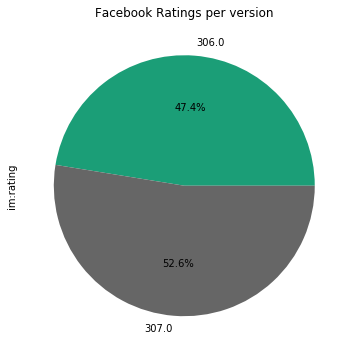

In [18]:
#Facebook
grouped = facebook.groupby('im:version')
facebook_ratings = grouped['im:rating'].agg(np.mean)

facebook_ratings.plot(kind='pie', x='im:version', y='im:rating', title = 'Facebook Ratings per version', 
cmap='Dark2', autopct="%.1f%%", figsize = (10,6), legend=False)
print(facebook_ratings)

im:version
1.184.1.2    4.500000
1.185.0.1    2.666667
1.186.0.3    3.000000
1.187.1.1    2.000000
1.188.0.4    2.615385
1.189.0.2    2.333333
1.190.0.2    2.500000
1.191.0.2    2.750000
1.192.0.1    2.708333
1.193.0.2    2.956522
1.194.0.2    2.953488
1.195.1.1    2.435897
1.196.0.1    3.098361
1.196.1.1    2.689655
Name: im:rating, dtype: float64


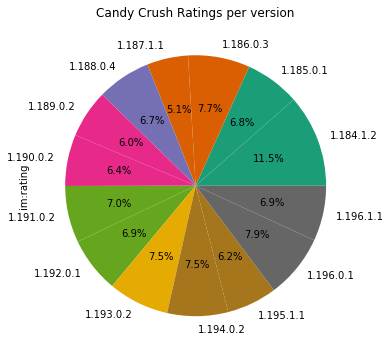

In [19]:
#Candy Crush
grouped = candyc.groupby('im:version')
candy_ratings = grouped['im:rating'].agg(np.mean)

candy_ratings.plot(kind='pie', x='im:version', y='im:rating', title = 'Candy Crush Ratings per version', 
cmap='Dark2', autopct="%.1f%%", figsize = (10,6), legend=False)
print(candy_ratings)

im:version
11.31.0    1.651163
12.1.0     1.433155
12.2.0     1.627219
Name: im:rating, dtype: float64


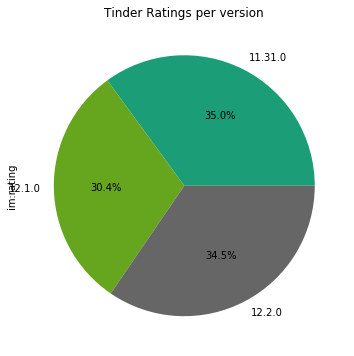

In [34]:
# Tinder
grouped = tinder.groupby('im:version')
tinder_ratings = grouped['im:rating'].agg(np.mean)

tinder_ratings.plot(kind='pie', x='im:version', y='im:rating', title = 'Tinder Ratings per version', 
cmap='Dark2', autopct="%.1f%%", figsize = (10,6), legend=False)
print(tinder_ratings)

#There happens to be an unnamed version in the data
#doesnt change much

im:version
8.50      1.000000
8.51      1.769231
8.52      2.111111
8.52.1    2.601695
8.53      3.083333
8.54      2.862500
8.54.5    2.908451
Name: im:rating, dtype: float64


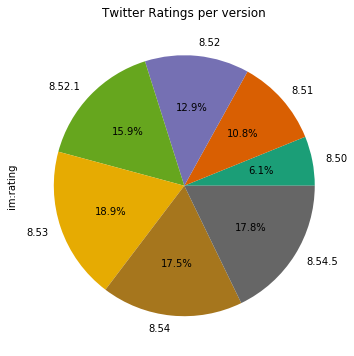

In [11]:
# Twitter
grouped = twitter.groupby('im:version')
twitter_ratings = grouped['im:rating'].agg(np.mean)


twitter_ratings.plot(kind='pie', x='im:version', y='im:rating', title = 'Twitter Ratings per version', 
cmap='Dark2', autopct="%.1f%%", figsize = (10,6), legend=False)
print(twitter_ratings)

# 2.3

In [7]:
fb5 = facebook.loc[facebook['im:rating'] == 5]
fb1 = facebook.loc[facebook['im:rating'] == 1]

cc5 = candyc.loc[candyc['im:rating'] == 5]
cc1 = candyc.loc[candyc['im:rating'] == 1]

twit5 = twitter.loc[twitter['im:rating'] == 5]
twit1 = twitter.loc[twitter['im:rating'] == 1]

tin5 = tinder.loc[tinder['im:rating'] == 5]
tin1 = tinder.loc[tinder['im:rating'] == 1]

In [ ]:
# Its interesting that the 1 star reviews for the social media sites
# All talk about cencorship.

# Facebook most common words for 5 star and 1 star ratings

In [35]:
from collections import Counter 
fb_5 = Counter(fb5['title'])
most_occur = fb_5.most_common(5) 
print(most_occur) 

[('Facebook', 8), ('Damascus Syria', 4), ('Alabama Ambassador', 4), ('Video', 4), ('Holà', 4)]


In [36]:
fb_1 = Counter(fb1['title'])
most_occur = fb_1.most_common(5) 
print(most_occur) 

[('Censorship', 108), ('Facebook', 24), ('Too much censorship', 12), ('Crashing', 12), ('Censor', 8)]


# candy crush most common words for 5 star and 1 star ratings

In [37]:
cc_5 = Counter(cc5['title'])
most_occur = cc_5.most_common(5) 
print(most_occur) 

[('Candy crush', 20), ('Candy Crush', 16), ('Candy crush saga', 8), ('Crashing', 8), ('Game', 8)]


In [38]:
cc_1 = Counter(cc1['title'])
most_occur = cc_1.most_common(5) 
print(most_occur) 

[('Candy crush', 16), ('Update', 8), ('Not loading', 8), ('Ads', 8), ('Can’t open app', 8)]


# twitter most common words for 5 star and 1 star ratings

In [39]:
twit_5 = Counter(twit5['title'])
most_occur = twit_5.most_common(5) 
print(most_occur) 

[('Twitter', 28), ('Review', 12), ('Best', 8), ('Rate', 8), ('Really good social networking app', 4)]


In [40]:
twit_1 = Counter(twit1['title'])
most_occur = twit_1.most_common(5) 
print(most_occur) 

[('Censorship', 32), ('Twitter', 12), ('Biased', 8), ('Free speech', 8), ('UNAMERICAN', 4)]


# Tinder most common words for 5 star and 1 star ratings

In [41]:
tin_5 = Counter(tin5['title'])
most_occur = tin_5.most_common(5) 
print(most_occur) 

[('How I could finally get something good out of tinder', 4), ('Found the love of my life', 4), ('Review', 4), ('Amazing app', 4), ('Death is imminent', 4)]


In [42]:
tin_1 = Counter(tin1['title'])
most_occur = tin_1.most_common(5) 
print(most_occur) 

[('Banned for no reason', 48), ('Doesn’t work', 12), ('banned for no reason', 12), ('awful', 8), ('Scam', 8)]


# 3 (STRETCH) IMDB scraping

IMDB has structured web pages. We can exploit this to scrape movie data.

Usinf the following URL:

`https://www.imdb.com/search/title/?groups=top_1000&start={PAGE_NUMBER}&ref_=adv_nxt`

With the following headers in your `GET` request: `{"Accept-Language": "en-US,en;q=0.5"}`

You can generate a dataframe like this one by cycling over the page numbers in the URL requested:

![](IMDB.png)

Note that the following  page attribues will be of interest:

- `div` with a class of `lister-item mode-advanced`

- Various `span` objects within that `div` like `lister-item-year` and `runtime` and `metascore`